# IA353 - Redes Neurais
# EFC4 - Questão 8
# Solving a Maze with Deep Reinforcement Learning

##### **Based on https://www.samyzaf.com/ML/rl/qmaze.html**

**Professor:** Fernando J. Von Zuben

**Aluno(a)**: Guilherme Rosa


### **1. Importações**

In [4]:
from __future__ import print_function
from time import sleep
from IPython import display

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU

import pylab as pl
import os, sys, time, datetime, json, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### **2. Definições**

#### **2.1. Definição de alguns parâmetros e do conjunto de ações do agente:**

In [5]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painted by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

#### **2.2. Definição da classe *Qmaze*:**

In [6]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):

    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)   # maze's array
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')  # ESTADO = Posição do rato 
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()  # salva a trajetória do rato

    def valid_actions(self, cell=None):

        # (row, col) fornece a posição atual (estado) do rato
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell

        actions = [0, 1, 2, 3] # todas as ações possíveis
        nrows, ncols = self.maze.shape

        if row == 0:
            actions.remove(1)  # se o rato está na primeira linha, a ação "UP" não é válida
        elif row == nrows-1:
            actions.remove(3)  # se o rato está na última linha, a ação "DOWN" não é válida

        if col == 0:
            actions.remove(0)  # se o rato está na primeira coluna, a ação "LEFT" não é válida
        elif col == ncols-1:
            actions.remove(2)  # se o rato está na última coluna, a ação "RIGHT" não é válida

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)  # se a célula acima estiver bloqueada, a ação "UP" não é válida
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)  # se a célula abaixo estiver bloqueada, a ação "DOWN" não é válida

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)  # se a célula à esquerda estiver bloqueada, a ação "LEFT" não é válida
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)  # se a célula à direita estiver bloqueada, a ação "RIGHT" não é válida

        return actions

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell 

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        
        if rat_row == nrows-1 and rat_col == ncols-1: # Alcançou o objetivo (pegar o queijo)
            return 1.0
        if mode == 'blocked': # Se não há ações válidas - Fim do jogo
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited: # Se o rato retornou para uma posição já visitada -> Penalização de -0.25 (Evitar repetição)
            return -0.25
        if mode == 'invalid': # Se o rato tomou uma ação inválida -> Penalização de -0.75
            return -0.75
        if mode == 'valid': # Se o rato tomou uma ação válida -> Penalização de -0.04 (Estimula o rato a encontrar o menor caminho entre a posição inicial e o queijo)
            return -0.04

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

#### **2.3. Definição da função que apresenta a figura do labirinto em um dado estado:**

In [7]:
def show(qmaze):
    
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

##### **2.3.1. Exemplo I:**

In [8]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

reward= -0.04


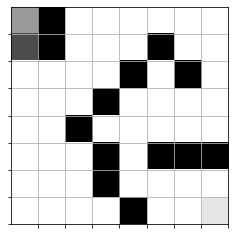

In [9]:
qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

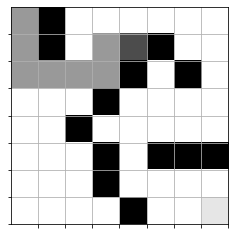

In [10]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
qmaze.act(RIGHT)  # move right
show(qmaze)

##### **2.3.2. Exemplo II:**

In [11]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.]
])

reward= -0.04


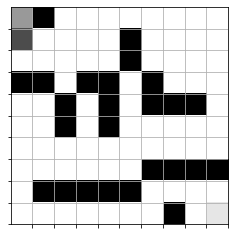

In [12]:
qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

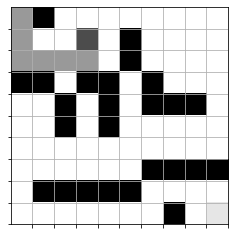

In [13]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

#### **2.4. Definição da função *play_game*:**

In [14]:
def play_game(model, qmaze, rat_cell):
  
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()

    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

#### **2.5. Definição da função *completion_check*:**

In [15]:
def completion_check(model, qmaze):

    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    
    return True

#### **2.6. Definição da classe *Experience*:**

In [16]:
class Experience(object):
  
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

#### **2.7. Definição da função de treinamento *qtrain*:**

In [17]:
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):     
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

#### **2.8. Definição da função de construção da rede neural *build_model*:**

In [18]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

### **3. Atividades práticas:**

#### **3.1. Execute o *notebook* para os dois labirintos propostos (execuções independentes, usando um de cada vez), apresentando os resultados do treinamento até a convergência, além de dois percursos para cada caso de estudo (com condições iniciais distintas), obtidos com a rede neural treinada.**

##### **3.1.1. Execução para o labirinto proposto I:**

- **Labirinto:**

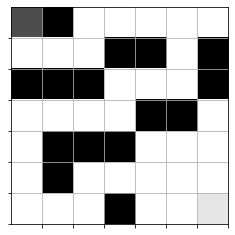

In [16]:
maze1 =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze1 = Qmaze(maze1)
show(qmaze1)

- **Treinamento e resultados:**

In [17]:
model1 = build_model(maze1)
qtrain(model1, maze1, epochs=1000, max_memory=8*maze1.size, data_size=32)

Epoch: 000/14999 | Loss: 0.0010 | Episodes: 108 | Win count: 0 | Win rate: 0.000 | time: 13.5 seconds
Epoch: 001/14999 | Loss: 0.0017 | Episodes: 107 | Win count: 0 | Win rate: 0.000 | time: 27.7 seconds
Epoch: 002/14999 | Loss: 0.0035 | Episodes: 104 | Win count: 0 | Win rate: 0.000 | time: 41.8 seconds
Epoch: 003/14999 | Loss: 0.0308 | Episodes: 104 | Win count: 0 | Win rate: 0.000 | time: 56.1 seconds
Epoch: 004/14999 | Loss: 0.0599 | Episodes: 105 | Win count: 0 | Win rate: 0.000 | time: 70.3 seconds
Epoch: 005/14999 | Loss: 0.0011 | Episodes: 103 | Win count: 0 | Win rate: 0.000 | time: 83.8 seconds
Epoch: 006/14999 | Loss: 0.1173 | Episodes: 4 | Win count: 1 | Win rate: 0.000 | time: 84.3 seconds
Epoch: 007/14999 | Loss: 0.0870 | Episodes: 101 | Win count: 1 | Win rate: 0.000 | time: 97.6 seconds
Epoch: 008/14999 | Loss: 0.0032 | Episodes: 108 | Win count: 1 | Win rate: 0.000 | time: 112.1 seconds
Epoch: 009/14999 | Loss: 0.0015 | Episodes: 105 | Win count: 1 | Win rate: 0.000 | 

610.707407

- **Apresentação do percurso realizado pelo modelo com o rato iniciando na posição (1, 1):**

In [18]:
random.seed(a=42)
rat_cell1 = random.choice(qmaze1.free_cells)
print(f'Posição inicial: {rat_cell1}')

Posição inicial: (1, 1)


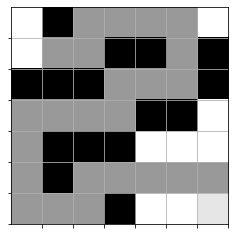

In [19]:
qmaze1.reset(rat_cell1)
envstate = qmaze1.observe()
game_status = 'lose'

q_values1 = []
rat_positions1 = []

while(game_status != 'win'):
    q = model1.predict(envstate)
    action = np.argmax(q[0])
    # action = np.argmax(model.predict(envstate))
    rat_status = qmaze1.state # posição do ratinho antes dele atuar no ambiente
    envstate, reward, game_status = qmaze1.act(action)

    rat_positions1.append(rat_status[:-1])
    q_values1.append(q)

    show(qmaze1)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.gca().clear()
    plt.close()
    sleep(0.2)

rat_positions1 = list(enumerate(rat_positions1))

- **Apresentação do percurso realizado pelo modelo com o rato iniciando na posição (3, 3):**

In [20]:
random.seed(a=13)
rat_cell1 = random.choice(qmaze1.free_cells)
print(f'Posição inicial: {rat_cell1}')

Posição inicial: (3, 3)


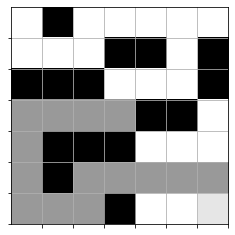

In [21]:
qmaze1.reset(rat_cell1)
envstate = qmaze1.observe()
game_status = 'lose'

while(game_status != 'win'):
    q = model1.predict(envstate)
    action = np.argmax(q[0])
    # action = np.argmax(model.predict(envstate))
    envstate, reward, game_status = qmaze1.act(action)
    show(qmaze1)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.gca().clear()
    plt.close()
    sleep(0.2)

##### **3.1.2. Execução para o labirinto proposto II:**

- **Labirinto:**

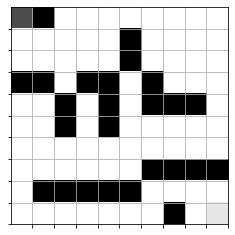

In [19]:
maze2 = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.]
])
qmaze2 = Qmaze(maze2)
show(qmaze2)

- **Treinamento e resultados:**

In [20]:
model2 = build_model(maze2)
qtrain(model2, maze2, epochs=1000, max_memory=8*maze2.size, data_size=32)

Epoch: 000/14999 | Loss: 0.0019 | Episodes: 220 | Win count: 0 | Win rate: 0.000 | time: 22.5 seconds
Epoch: 001/14999 | Loss: 0.0019 | Episodes: 207 | Win count: 0 | Win rate: 0.000 | time: 42.7 seconds
Epoch: 002/14999 | Loss: 0.0607 | Episodes: 218 | Win count: 0 | Win rate: 0.000 | time: 64.2 seconds
Epoch: 003/14999 | Loss: 0.0013 | Episodes: 221 | Win count: 0 | Win rate: 0.000 | time: 86.3 seconds
Epoch: 004/14999 | Loss: 0.0013 | Episodes: 231 | Win count: 0 | Win rate: 0.000 | time: 109.3 seconds
Epoch: 005/14999 | Loss: 0.0012 | Episodes: 218 | Win count: 0 | Win rate: 0.000 | time: 131.0 seconds
Epoch: 006/14999 | Loss: 0.0015 | Episodes: 219 | Win count: 0 | Win rate: 0.000 | time: 152.6 seconds
Epoch: 007/14999 | Loss: 0.0018 | Episodes: 212 | Win count: 0 | Win rate: 0.000 | time: 173.3 seconds
Epoch: 008/14999 | Loss: 0.0010 | Episodes: 61 | Win count: 1 | Win rate: 0.000 | time: 179.1 seconds
Epoch: 009/14999 | Loss: 0.0284 | Episodes: 233 | Win count: 1 | Win rate: 0.0

944.721647

- **Apresentação do percurso realizado pelo modelo com o rato iniciando na posição (, ):**

In [21]:
random.seed(a=42)
rat_cell2 = random.choice(qmaze2.free_cells)
print(f'Posição inicial: {rat_cell2}')

Posição inicial: (1, 6)


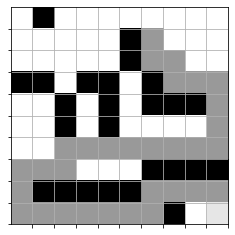

In [22]:
qmaze2.reset(rat_cell2)
envstate = qmaze2.observe()
game_status = 'lose'

q_values2 = []
rat_positions2 = []

while(game_status != 'win'):
    q = model2.predict(envstate)
    action = np.argmax(q[0])
    # action = np.argmax(model.predict(envstate))
    rat_status = qmaze2.state # posição do ratinho antes dele atuar no ambiente
    envstate, reward, game_status = qmaze2.act(action)

    rat_positions2.append(rat_status[:-1])
    q_values2.append(q)

    show(qmaze2)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.gca().clear()
    plt.close()
    sleep(0.2)

rat_positions2 = list(enumerate(rat_positions2))

- **Apresentação do percurso realizado pelo modelo com o rato iniciando na posição (, ):**

In [23]:
random.seed(a=13)
rat_cell2 = random.choice(qmaze2.free_cells)
print(f'Posição inicial: {rat_cell2}')

Posição inicial: (4, 1)


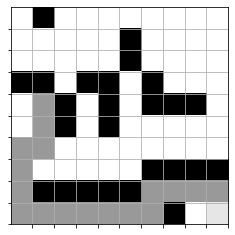

In [24]:
qmaze2.reset(rat_cell2)
envstate = qmaze2.observe()
game_status = 'lose'

while(game_status != 'win'):
  q = model2.predict(envstate)
  action = np.argmax(q[0])
  # action = np.argmax(model.predict(envstate))
  envstate, reward, game_status = qmaze2.act(action)
  show(qmaze2)
  display.clear_output(wait=True)
  display.display(pl.gcf())
  plt.gca().clear()
  plt.close()
  sleep(0.2)

#### **3.2. Para esses dois casos de estudo, apresente os 4 valores da função Q-valor para 3 estados representativos do ambiente, produzidos pela rede neural treinada.**

- **Caso de estudo - Labirinto proposto I (subseção 3.1.1): Apresentação do função Q-valor para 3 estados representativos do ambiente**

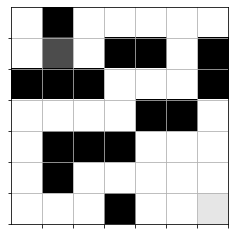

In [28]:
qmaze1.reset(rat_positions1[0][1])
show(qmaze1);

In [32]:
for i in range(0, 3):
    idx, rat_position = random.choice(list(rat_positions1))
    print('-------------------------------------------------------------------')
    print(f'Posição do rato: {rat_position}')
    print(f'Função Q-valor: {q_values1[idx]}')
    print(f'Ação tomada: {actions_dict[np.argmax(q_values1[idx])]}')

-------------------------------------------------------------------
Posição do rato: (0, 5)
Função Q-valor: [[-0.43571314 -0.58924776 -0.33554417 -0.27582842]]
Ação tomada: down
-------------------------------------------------------------------
Posição do rato: (5, 3)
Função Q-valor: [[0.20439735 0.46279466 0.75450486 0.33679938]]
Ação tomada: right
-------------------------------------------------------------------
Posição do rato: (2, 5)
Função Q-valor: [[-0.25152257 -0.6023271  -0.47616285 -0.37664127]]
Ação tomada: left


- **Caso de estudo - Labirinto proposto II (subseção 3.1.2): Apresentação do função Q-valor para 3 estados representativos do ambiente**

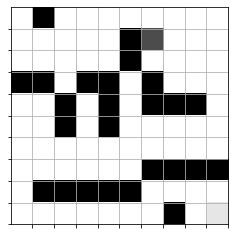

In [25]:
qmaze2.reset(rat_positions2[0][1])
show(qmaze2);

In [32]:
for i in range(0, 3):
    idx, rat_position = random.choice(list(rat_positions2))
    print('-------------------------------------------------------------------')
    print(f'Posição do rato: {rat_position}')
    print(f'Função Q-valor: {q_values2[idx]}')
    print(f'Ação tomada: {actions_dict[np.argmax(q_values2[idx])]}')

-------------------------------------------------------------------
Posição do rato: (2, 7)
Função Q-valor: [[-0.7811699  -0.7420155  -0.6791441  -0.48888922]]
Ação tomada: down
-------------------------------------------------------------------
Posição do rato: (7, 1)
Função Q-valor: [[-0.00362578 -0.53077996 -0.24604756 -0.154458  ]]
Ação tomada: left
-------------------------------------------------------------------
Posição do rato: (8, 6)
Função Q-valor: [[ 0.20405135 -0.5634073   0.73469174  0.31996697]]
Ação tomada: right


#### **3.3. Explique como é definida a função de erro quadrático médio usada no treinamento.**



- Nesse problema de aprendizado por reforço é explorada a técnica *Deep Q-Learning*, que busca aproximar, por meio do treinamento de uma rede neural, uma função Q-valor que satisfaça o Princípio de Otimalidade de Bellman.

- A função Q-valor indica a recompensa acumulada esperada quando o agente segue uma política $\pi$ a partir de um par estado-ação. Portanto, a função Q-valor ótima é aquela que maximiza a recompensa acumulada esperada quando o agente segue uma política $\pi$ a partir de um par estado-ação.

- Para satisfazer o Princípio de Otimalidade de Bellman, a função Q-valor ótima deve satisfazer a Equação de Bellman, apresentada a seguir:

$$
Q^{*}(s, a) = \mathbb{E}[r + \gamma\max_{a'}Q^{*}(s', a')|s, a]
$$

onde $(s,a)$ é o par estado-ação no instante atual e $(s', a')$ é o par estado-ação no instante seguinte. Logo, a equação de Belmman é recursiva e, quando satisfeita, faz com que o agente tome para cada estado a ação que maximiza a recompensa acumulada esperada.

- Para obter uma aproximação da função Q-valor, o treinamento da rede neural tem como objetivo fazer com que os lados direito e esquerdo da equação de Belmman sejam iguais, isto é:

$$
Q^{*}(s, a) \approx \mathbb{E}[r + \gamma\max_{a'}Q^{*}(s', a')|s, a]
$$
$$
\mathbb{E}[r + \gamma\max_{a'}Q^{*}(s', a')|s, a] - Q^{*}(s, a) \approx 0
$$

- Minimizar a diferença (o erro) entre os dois lados da equação pode ser feita com o uso da função erro quadrático médio como função custo:
$$
L_i(\theta_i) = \mathbb{E}[(\mathbb{E}[r + \gamma\max_{a'}Q^{*}(s', a', \theta_{i-1})|s, a] - Q^{*}(s, a, \theta_i))^2]]
$$

- O termo $\mathbb{E}[r + \gamma\max_{a'}Q^{*}(s', a', \theta_{i-1})|s, a]$ pode ser visto como a saída desejada, enquanto o termo $Q^{*}(s, a, \theta_i)$ pode ser visto como a saída predita pelo modelo.

- O código que implementa as saídas desejadas é apresentado abaixo.

```
inputs = np.zeros((data_size, env_size))
targets = np.zeros((data_size, self.num_actions))
for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):

    envstate, action, reward, envstate_next, game_over = self.memory[j]
    inputs[i] = envstate
    # There should be no target values for actions not taken.
    targets[i] = self.predict(envstate)
    # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
    Q_sa = np.max(self.predict(envstate_next))
    if game_over:
        targets[i, action] = reward
    else:
        # reward + gamma * max_a' Q(s', a')
        targets[i, action] = reward + self.discount * Q_sa
```

- O erro quadrático médio é tomado entre a função Q-valor predita pela rede e a função contida na variável *target*.

- É importante destacar que os valores da função Q-valor predita pela rede para as ações que não foram tomadas são iguais tanto no estado atual quanto no estado seguinte. Dessa forma, quando o erro quadrático médio é calculado, o erro referente à esses elementos é nulo.

#### **3.4. Explique como é trabalhada a técnica de *experience replay*.**

- A técnica de *experience replay* é utilizada no treinamento da rede neural. 

- Esta técnica utiliza a variável *episode*, que é uma tupla de 5 elementos criada após uma ação do agente e que contém:
  - *envstate*: estado atual do ambiente
  - *action*: ação tomada pelo agente
  - *reward*: ação recebida pelo agente após realizar a ação *action*
  - *envstate_next*: estado seguinte do ambiente após a ação ser tomada
  - *game_over*: variável que indica se o jogo terminou (com vitória ou derrota)

- Uma época de treinamento do modelo começa com o rato na posição inicial e termina com uma vitória ou derrota.

- Enquanto o jogo (época) não termina:

  - O agente toma uma ação (exploratória ou explotatória), cria um episódio e salva na memória.

    - O tamanho da memória representa o número máximo de episódios armazenados. Se o número máximo é atingido, o episódio mais antigo é removido e o novo episódio é integrado à memória.

  - O modelo é treinado com um conjunto aleatório de episódios armazenados da memória (*batch*), conforme apresentado na seção 3.3 (*experience replay*).

- Portanto, em cada época de treinamento, o modelo é treinado com vários conjuntos de episódios já vivenciados pelo agente tanto naquela época quanto em épocas anteriores.